In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === DP Config Mapping ===
cfg_map = {
    "eps0.05": "ε = 0.1",
    "eps1": "ε = 1",
    "eps3": "ε = 3",
    "eps8": "ε = 10"
}

# === Load server logs ===
base_dir = "."
all_data = {}

for cfg_key, config_label in cfg_map.items():
    runs = []
    for run_folder in os.listdir(base_dir):
        if run_folder.startswith(f"exp_dp_{cfg_key}_r"):
            log_root = os.path.join(base_dir, run_folder)
            subfolders = [
                f for f in os.listdir(log_root)
                if f.startswith("log_server_") and os.path.isdir(os.path.join(log_root, f))
            ]
            if not subfolders:
                continue
            log_path = os.path.join(log_root, subfolders[0], "server_log.csv")
            if os.path.exists(log_path):
                df = pd.read_csv(log_path)
                runs.append(df)

    all_data[config_label] = runs

# === Compute and print avg training time per config ===
train_time_summary = {}
for config, runs in all_data.items():
    all_times = []
    for df in runs:
        if not df.empty and "Round Duration (s)" in df.columns:
            all_times.extend(df["Round Duration (s)"].dropna().tolist())

    if all_times:
        train_time_summary[config] = round(np.mean(all_times), 2)

for config, avg_time in train_time_summary.items():
    print(f"{config}: {avg_time} seconds")


ε = 0.05: 40.63 seconds
ε = 1: 39.05 seconds
ε = 3: 26.51 seconds
ε = 10: 39.39 seconds


/tmp/ipykernel_148440/1043754551.py:39: RuntimeWarning: Mean of empty slice
  "mean": np.nanmean(f1_array, axis=0),
/tmp/ipykernel_148440/1043754551.py:45: RuntimeWarning: Mean of empty slice
  "mean": np.nanmean(time_array, axis=0),


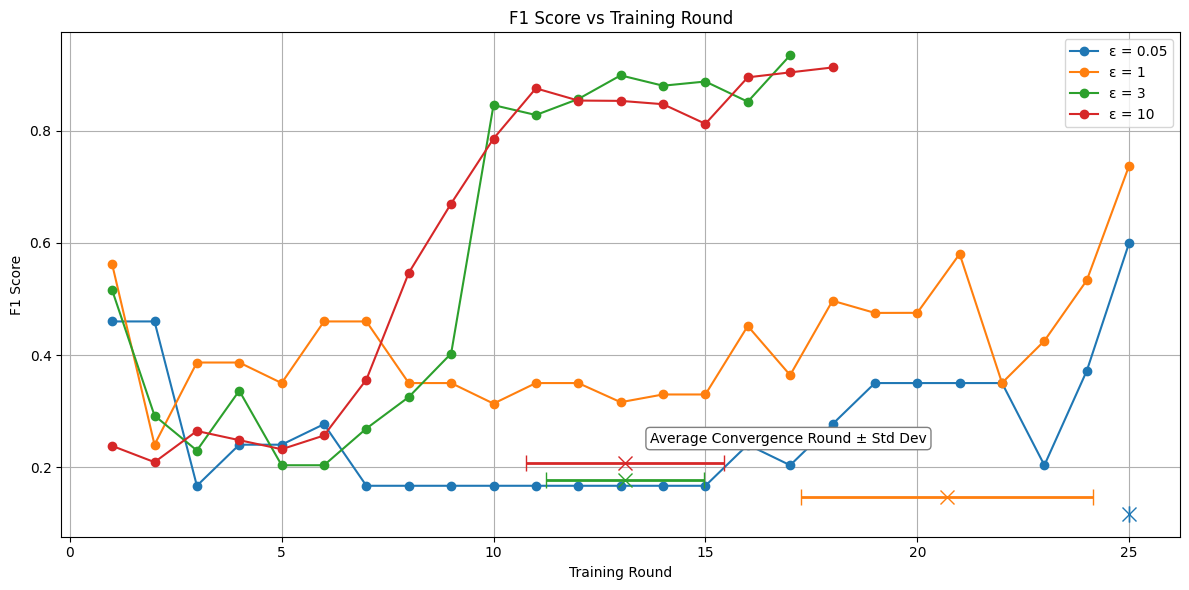

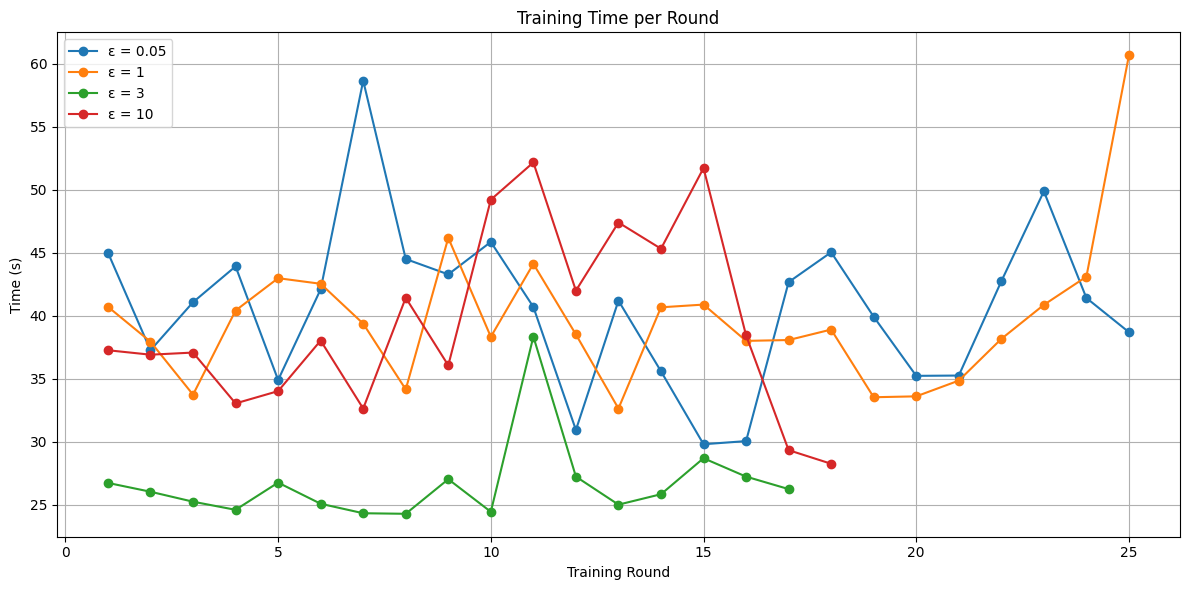

In [11]:
# === Toggle STD DEV Visualization ===
SHOW_STD_DEV = False
USE_ERROR_BARS = False

# === Prepare data ===
max_rounds = 0
f1_stats = {}
time_stats = {}

# Determine max rounds
for config, runs in all_data.items():
    max_rounds = max(max_rounds, max(len(df) for df in runs if not df.empty))

# Gather and pad metrics
for config, runs in all_data.items():
    f1_matrix = []
    time_matrix = []
    stop_rounds = []

    for df in runs:
        if df.empty:
            continue
        f1_series = df["F1 Score"].values
        time_series = df["Round Duration (s)"].values
        stop_rounds.append(len(f1_series))

        f1_padded = np.full(max_rounds, np.nan)
        time_padded = np.full(max_rounds, np.nan)
        f1_padded[:len(f1_series)] = f1_series
        time_padded[:len(time_series)] = time_series

        f1_matrix.append(f1_padded)
        time_matrix.append(time_padded)

    f1_array = np.vstack(f1_matrix)
    time_array = np.vstack(time_matrix)

    f1_stats[config] = {
        "mean": np.nanmean(f1_array, axis=0),
        "std": np.nanstd(f1_array, axis=0),
        "stop_rounds": stop_rounds
    }

    time_stats[config] = {
        "mean": np.nanmean(time_array, axis=0),
        "std": np.nanstd(time_array, axis=0),
        "stop_rounds": stop_rounds
    }

rounds = np.arange(1, max_rounds + 1)
colors = plt.cm.tab10.colors

# === F1 Score Plot with stacked convergence markers ===
plt.figure(figsize=(12, 6))
min_y = min(np.nanmin(stats["mean"]) for stats in f1_stats.values())
base_marker_y = min_y - 0.05
marker_spacing = 0.03

for idx, (config, stats) in enumerate(f1_stats.items()):
    mean = stats["mean"]
    std = stats["std"]
    stop_rounds = stats["stop_rounds"]
    color = colors[idx]

    if SHOW_STD_DEV:
        if USE_ERROR_BARS:
            plt.errorbar(rounds, mean, yerr=std, label=config, fmt='-o', capsize=4, color=color)
        else:
            plt.plot(rounds, mean, label=config, color=color)
            plt.fill_between(rounds, mean - std, mean + std, alpha=0.3, color=color)
    else:
        plt.plot(rounds, mean, label=config, color=color, marker='o')

    avg_stop = np.mean(stop_rounds)
    std_stop = np.std(stop_rounds)
    marker_y = base_marker_y + idx * marker_spacing
    plt.errorbar(avg_stop, marker_y, xerr=std_stop, fmt='x', color=color,
                 markersize=10, capsize=6, elinewidth=2)

# Annotate marker axis
top_label_y = base_marker_y + len(f1_stats) * marker_spacing - 0.05
plt.annotate("Average Convergence Round ± Std Dev",
             xy=(0.65, top_label_y), xycoords='axes fraction',
             ha='center', fontsize=10,
             bbox=dict(boxstyle="round", fc="white", ec="gray"))

plt.title("F1 Score vs Training Round")
plt.xlabel("Training Round")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Training Time Plot ===
plt.figure(figsize=(12, 6))
for idx, (config, stats) in enumerate(time_stats.items()):
    mean = stats["mean"]
    std = stats["std"]
    color = colors[idx]

    if SHOW_STD_DEV:
        if USE_ERROR_BARS:
            plt.errorbar(rounds, mean, yerr=std, label=config, fmt='-o', capsize=4, color=color)
        else:
            plt.plot(rounds, mean, label=config, color=color)
            plt.fill_between(rounds, mean - std, mean + std, alpha=0.3, color=color)
    else:
        plt.plot(rounds, mean, label=config, color=color, marker='o')

plt.title("Training Time per Round")
plt.xlabel("Training Round")
plt.ylabel("Time (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict

base_dir = "."  # or path to your experiment root

# Map config folder prefix to label
config_map = {
    "light": "CKKS Light",
    "med": "CKKS Medium",
    "heavy": "CKKS Heavy"
}

# Metrics to extract
cpu_metrics = ["Avg CPU (%)", "Peak CPU (%)"]
mem_metrics = ["Avg Memory (MB)", "Peak Memory (MB)"]

# Storage
cpu_data = {label: {metric: defaultdict(list) for metric in cpu_metrics} for label in config_map.values()}
mem_data = {label: {metric: defaultdict(list) for metric in mem_metrics} for label in config_map.values()}

# Walk all experiment folders
for folder in os.listdir(base_dir):
    for cfg_prefix, label in config_map.items():
        if folder.startswith(f"exp_{cfg_prefix}_r"):
            try:
                log_folder = [
                    f for f in os.listdir(os.path.join(base_dir, folder))
                    if f.startswith("log_clients_")
                ][0]
                csv_path = os.path.join(base_dir, folder, log_folder, "client_0", "metrics_log.csv")
                df = pd.read_csv(csv_path)

                for _, row in df.iterrows():
                    round_num = int(row["Round"])
                    for metric in cpu_metrics:
                        value = row.get(metric, None)
                        if pd.notnull(value):
                            cpu_data[label][metric][round_num].append(value)
                    for metric in mem_metrics:
                        value = row.get(metric, None)
                        if pd.notnull(value):
                            mem_data[label][metric][round_num].append(value)
            except Exception as e:
                print(f"❌ Failed to load from {folder}: {e}")


In [4]:
# Combine CPU and Memory into one summary table
summary_rows = []

for config in config_map.values():
    row = {"Config": config}

    for metric in cpu_metrics:
        all_vals = []
        for round_vals in cpu_data[config][metric].values():
            all_vals.extend(round_vals)
        row[metric] = round(np.mean(all_vals), 2) if all_vals else "-"

    for metric in mem_metrics:
        all_vals = []
        for round_vals in mem_data[config][metric].values():
            all_vals.extend(round_vals)
        row[metric] = round(np.mean(all_vals), 2) if all_vals else "-"

    summary_rows.append(row)

client_summary_df = pd.DataFrame(summary_rows).set_index("Config")
display(client_summary_df)


,Avg CPU (%),Peak CPU (%),Avg Memory (MB),Peak Memory (MB)
Config,,,,
CKKS Light,40.88,48.41,1476.11,1483.40
CKKS Medium,41.76,48.88,1433.68,1439.99
CKKS Heavy,38.50,48.20,1508.79,1518.01
